In [1]:
# filter(x -> occursin("SLURM", x), keys(ENV))
#ENV["SLURM_NNODES"]
#parse(Int, ENV["SLURM_JOB_CPUS_PER_NODE"])
pwd()

"/Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration"

In [2]:
# activate environment
using Pkg; Pkg.activate(".")

import ClimaAtmos as CA
import ClimaAnalysis: SimDir, get, slice, average_xy
using CairoMakie
import JLD2
import LinearAlgebra: I
import EnsembleKalmanProcesses as EKP
import Statistics: var, mean
using Test
using Revise

# include("observation_map.jl")

# using Revise
# import ClimaCalibrate as CAL
# import ClimaAtmos as CA
# experiment_dir = joinpath(pkgdir(CA), "calibration", "experiments", "gcm_driven_scm")
# model_interface =
#     joinpath(pkgdir(CA), "calibration", "model_interface.jl")
# output_dir = joinpath("output", "gcm_driven_scm")
# # include model interface
# includet(model_interface)
# obs_path = joinpath(experiment_dir, "observations.jld2")


  Activating project at `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/local_calibration`


## Calibration Evaluation and Setup

In [3]:
observations = JLD2.load_object(obs_path)
noise = 0.1 * I
n_iterations = 3
ensemble_size = 9
prior = CAL.get_prior(joinpath(experiment_dir, "prior.toml"))
experiment_config = CAL.ExperimentConfig(;
    n_iterations,
    ensemble_size,
    observations,
    noise,
    output_dir,
    prior,
)

InterruptException: InterruptException:

In [11]:
obs_path = joinpath(experiment_dir, "observations.jld2")
observations = JLD2.load_object(obs_path)
observations

1-element Vector{Float64}:
 285.0

In [ ]:
@everywhere begin
    using JLD2
    experiment_dir = dirname(Base.active_project())
    obs_path = joinpath(experiment_dir, "observations.jld2")
    if !isfile(obs_path)
        error("Observation file not found at: $obs_path")
    else
        println("Worker ", myid(), " can access the observations file.")
    end
end

In [ ]:
reshape(G_ens[1,:], 1, 10)
EKP.update_ensemble!(eki, reshape(G_ens[1,:], 1, 10))
CAL.save_eki_state(eki, output_dir, 1, prior)

## Visualization

In [4]:
# imports 
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
using EnsembleKalmanProcesses.TOMLInterface
using Distributions
import Statistics: mean
import CairoMakie: Makie
import ClimaCalibrate

In [19]:
function convergence_plot(
    eki::EKP.EnsembleKalmanProcess,
    prior::ParameterDistribution;
    theta_star = 65.0,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    u_vec = EKP.get_u(eki)
    meanabsdiff²(x, e) = sum(i -> abs(i - x)^2, e) / length(e)
    error_vec = map(ensemble -> meanabsdiff²(theta_star, ensemble), u_vec)
    spread_vec = map(ensemble -> meanabsdiff²(mean(ensemble), ensemble), u_vec)
    phi_vec = transform_unconstrained_to_constrained(prior, u_vec)
    u_series = eachcol(reduce(vcat, u_vec))
    phi_series = eachcol(reduce(vcat, phi_vec))

    f = Makie.Figure(title = "Convergence Plot", resolution = (800, 800))

    ax = Makie.Axis(
        f[1, 1],
        xlabel = "Iteration",
        ylabel = "Error",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(error_vec) - 1), error_vec)

    ax = Makie.Axis(
        f[1, 2],
        xlabel = "Iteration",
        ylabel = "Spread",
        xticks = 0:50,
    )
    Makie.lines!(ax, 0.0:(length(spread_vec) - 1), spread_vec)

    ax = Makie.Axis(
        f[2, 1],
        xlabel = "Iteration",
        ylabel = "Unconstrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(u_series[1]) - 1)), u_series)

    ax = Makie.Axis(
        f[2, 2],
        xlabel = "Iteration",
        ylabel = "Constrained Parameters",
        xticks = 0:50,
    )
    Makie.lines!.(ax, tuple(0.0:(length(phi_series[1]) - 1)), phi_series)
    #Makie.hlines!(ax, [theta_star], color = :red, linestyle = :dash)
    Makie.save(joinpath(output, "convergence.png"), f)
end

function scatter_plot(
    eki,
    output = joinpath("output", "sphere_held_suarez_rhoe_equilmoist"),
)
    # Define figure with explicit size
    f = Makie.Figure(resolution = (800, 600))
    a = Makie.Axis(
        f[1, 1],
        title = "60-Day Zonal Avg Temp at 242m versus Unconstrained Equator-Pole Temp Gradient",
        ylabel = "Parameter Value",
        xlabel = "Temperature (K)",
    )

    g = vec.(EKP.get_g(eki; return_array = true))
    u = vec.(EKP.get_u(eki; return_array = true))

    for (gg, uu) in zip(g, u)
        Makie.scatter!(a, gg, uu)
    end

    # Save the figure
    Makie.save(joinpath(output, "scatter.png"), f)
end

scatter_plot (generic function with 2 methods)

In [5]:
import JLD2
iteration = 5
output_dir = joinpath("output", "gcm_driven_scm")
eki_filepath = joinpath(ClimaCalibrate.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
prior_path = joinpath("prior.toml")
prior = ClimaCalibrate.get_prior(prior_path)


ParameterDistribution with 5 entries: 
'mixing_length_eddy_viscosity_coefficient' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.9686573911265683, σ=0.07133771448169109)) 
'detr_massflux_vertdiv_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=0.13599544622138604, σ=0.0867928125339026)) 
'entr_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.20894796975252, σ=0.09975134511959267)) 
'entr_inv_tau' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-9.215315537402766, σ=0.09975134511959267)) 
'mixing_length_diss_coeff' with Constraint{BoundedBelow}[Bounds: (0.0, ∞)] over distribution Parameterized(Normal{Float64}(μ=-1.5151597247402013, σ=0.045431093106500196)) 


In [27]:
size(vcat(EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))...), 2)

15

In [28]:
names = EKP.get_name(prior)

# get parameter data and put in matrix form 
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))
params = vcat(params...)
params = reshape(params, length(names), eki.N_ens, iteration+1)
params = permutedims(params, (3, 1, 2));

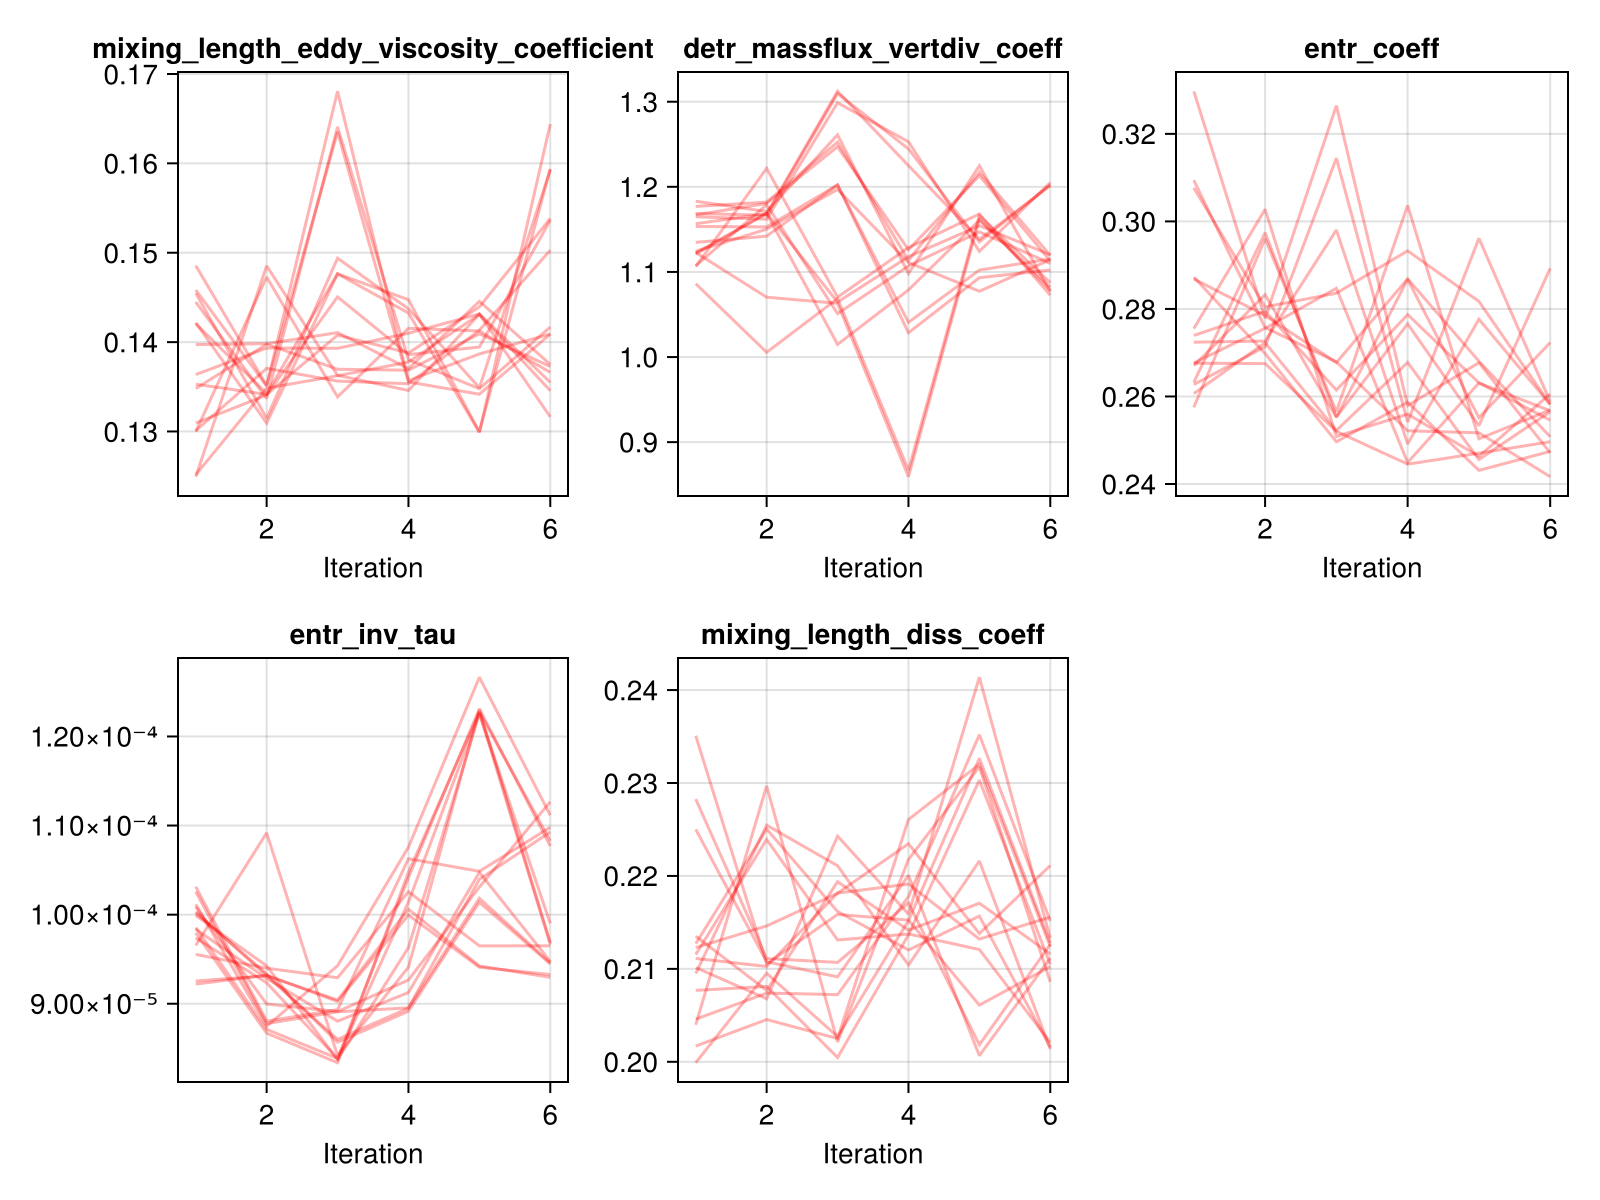

In [106]:
fig = Figure(size = (800, 600))

num_per_row = 3
for i in 1:length(names)
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = names[i], xlabel = "Iteration")
    
    for j in 1:size(params, 3)
        lines!(ax, 1:size(params, 1), params[:, i, j], color = :red, alpha = 0.3)
    end
end
fig

In [15]:
# create a similar plot but show the loss function value (e.g., rlut) instead of the parameter value
fieldnames(EKP.EnsembleKalmanProcess)

(:u, :observation_series, :N_ens, :g, :err, :scheduler, :accelerator, :Δt, :process, :rng, :failure_handler, :localizer, :verbose)

In [80]:
mean(loss_vals[1,:][(!).(isnan.(loss_vals[1, :]))])

276.5868225097656

In [87]:
function mean_ignore_nan(arr, dim)
    mean_values = mapslices(x -> mean(x[(!).(isnan.(x))]), arr, dims=dim)
    return vec(mean_values)
end

mean_ignore_nan(loss_vals, 2)

5-element Vector{Float64}:
 276.5868225097656
 276.3648173014323
 275.94365844726565
 275.67548217773435
 275.2759053548177

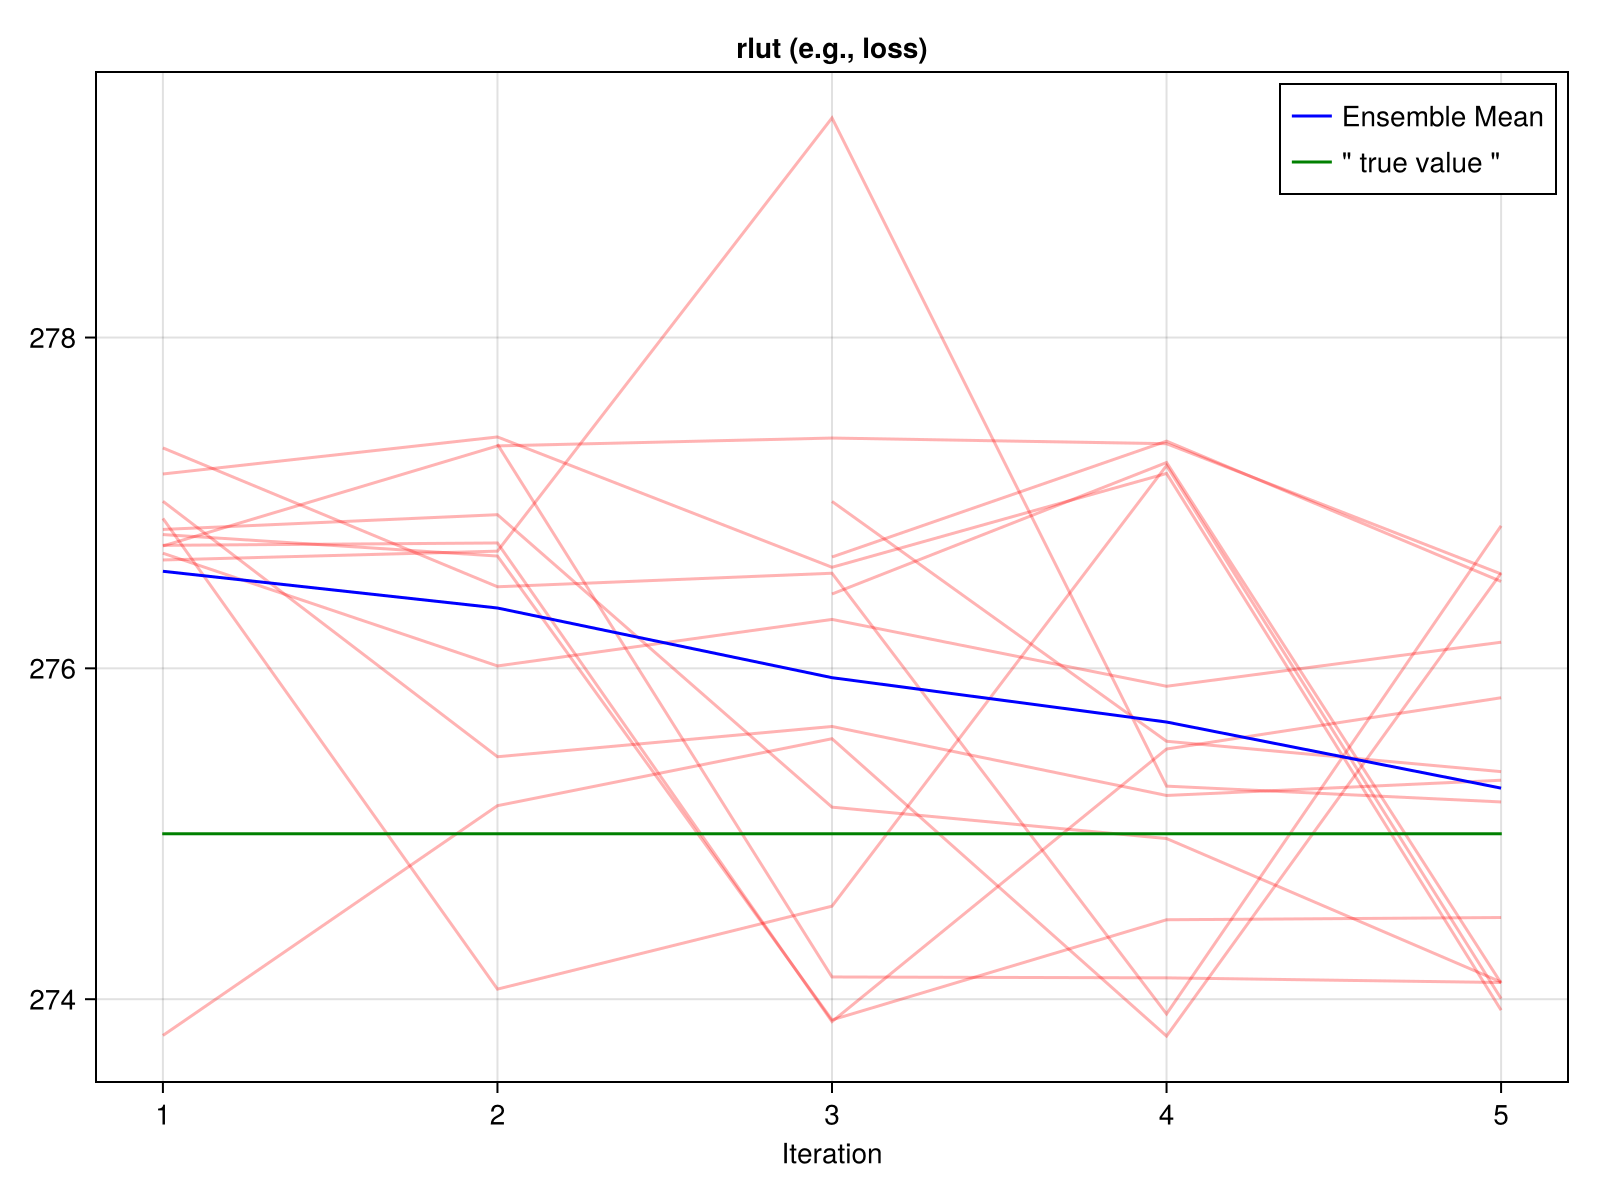

In [107]:
loss_vals = vcat(EKP.get_g(eki)...)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], title = "rlut (e.g., loss)", xlabel = "Iteration")
for i in 1:size(loss_vals, 2)
    lines!(ax, 1:size(loss_vals, 1), loss_vals[:, i], color = :red, alpha = 0.3)
end
lines!(ax, 1:size(loss_vals, 1), mean_ignore_nan(loss_vals, 2), color = :blue, label = "Ensemble Mean")
hlines!(ax, [275], xmin = .045, xmax= .955, color = :green, label = "\" true value \"")
# legend = Legend(fig, ax, tellwidth = false, tellheight = false)
# fig[1, 2] = legend
axislegend(ax, position = :rt)
fig
# size(loss_vals, 1)
# loss_vals[1][:]

# reshape loss_vals to be matrix 
# size(loss_vals)

In [145]:
# generate some plots of all variables for different simulations
# argmin(abs.(loss_vals .- 275))
best = argmin(replace(abs.(loss_vals .-275), NaN => Inf))
worst = argmax(replace(abs.(loss_vals .-275), NaN => -Inf))

println("Best: ", best, loss_vals[best])
println("Worst: ", worst, loss_vals[worst])


Best: CartesianIndex(4, 3)274.9712219238281
Worst: CartesianIndex(3, 6)279.3276062011719


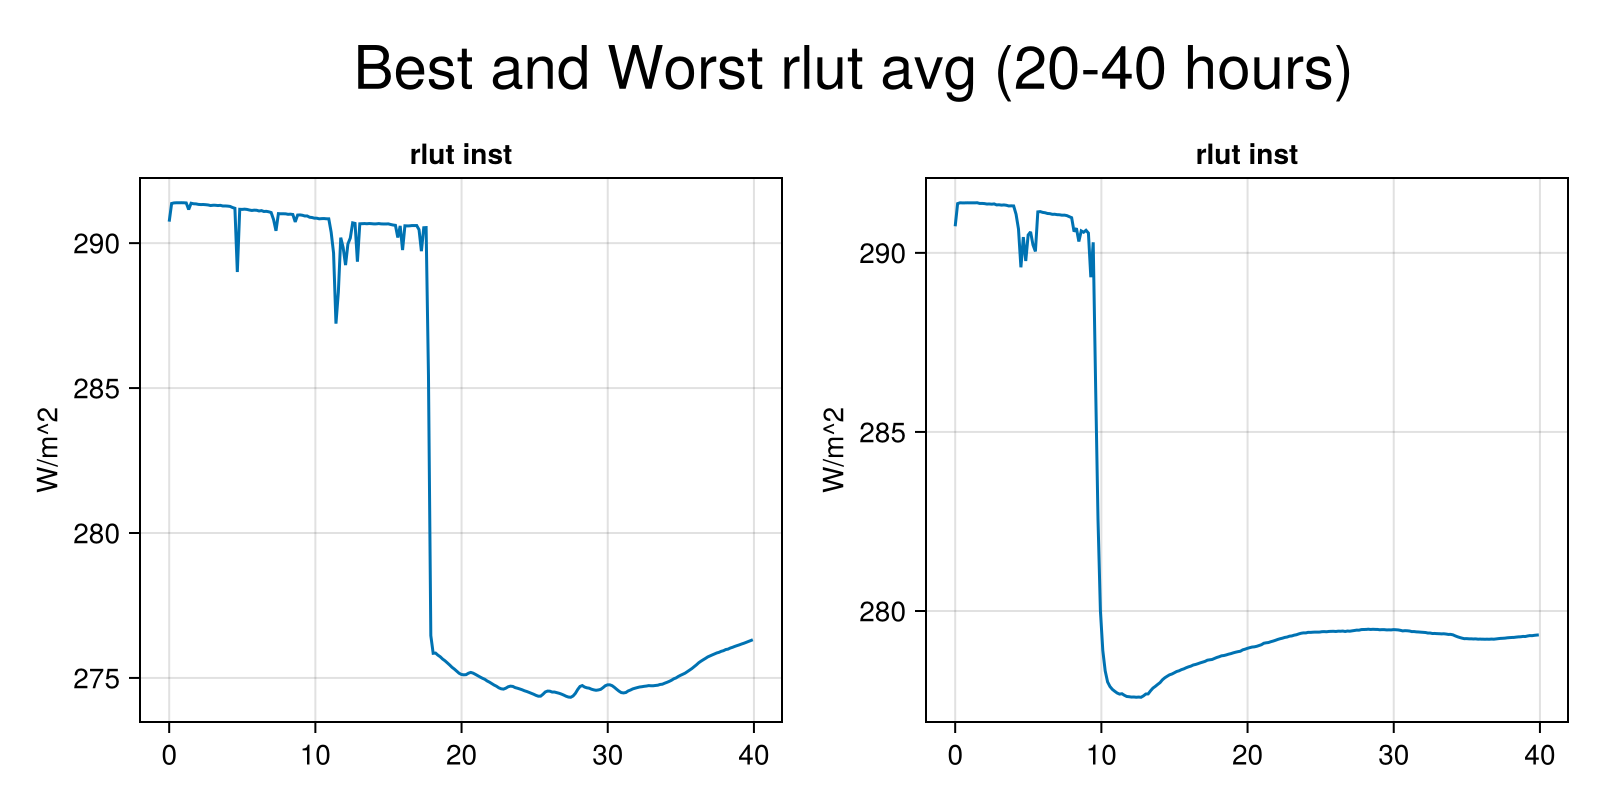

In [149]:
fig = Figure(size = (800, 400))
min_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))
max_simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

add_var(fig, "rlut", min_simdir, 1, 1, lines = true)
add_var(fig, "rlut", max_simdir, 1, 2, lines = true)
supertitle = Label(fig[0, :], "Best and Worst rlut avg (20-40 hours)", fontsize = 30)

fig

In [3]:
#simdir = SimDir(joinpath("output", "gcm_driven_scm", "iteration_004", "member_001","output_active"))
# println(summary(simdir))

function add_var(fig, var, simdir = simdir, col = 1, ind = 1; lines = false, reduction = "inst")
    # get data 
    da = get(simdir; short_name = var, reduction = "inst")
    title = "$var $reduction"
    if lines
        ax = Axis(fig[col, ind], ylabel = "W/m^2", title = title)
        ln = lines!(da.dims["time"]/ 21600*6, da.data[:, 1, 1])
       # Colorbar(fig[col, ind+1], ln, label = var)
    elseif var == "wa"
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"][1:end]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[1:end, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    else
        ax = Axis(fig[col, ind][1, 1], ylabel = "height (km)", xlabel="time (hrs)", title = title)
        hm = heatmap!(da.dims["time"]/ 21600*6, 
                      da.dims["z"][1:20]/1000,
                      da.data[:, 1, 1, 1:20])
        Colorbar(fig[col, ind][1,2], hm)
    end
end

function plot_defaults(dirname)
    simdir = SimDir(dirname)

    fig = Figure(size=(1400,800))

    vars = ["clw", "wa", "entr", "hus", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke"]
    for (ind, var) in enumerate(["ta", "wa", "clw", "cl", "rlut", "rlutcs", "rsut", "rsutcs", "waup", "tke", "arup", "entr", "detr"])
        if var in ["rlut", "rlutcs", "rsut", "rsutcs"] # add lines
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1, lines = true)
        else
            add_var(fig, var, simdir, ind % 4 + 1, div(ind, 4) + 1)
        end
    end
    add_var(fig, "tke", simdir, 1, 1, lines = false, reduction = "max")

    fig 
end

plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_003", "member_003","output_active"))

plot_defaults (generic function with 1 method)

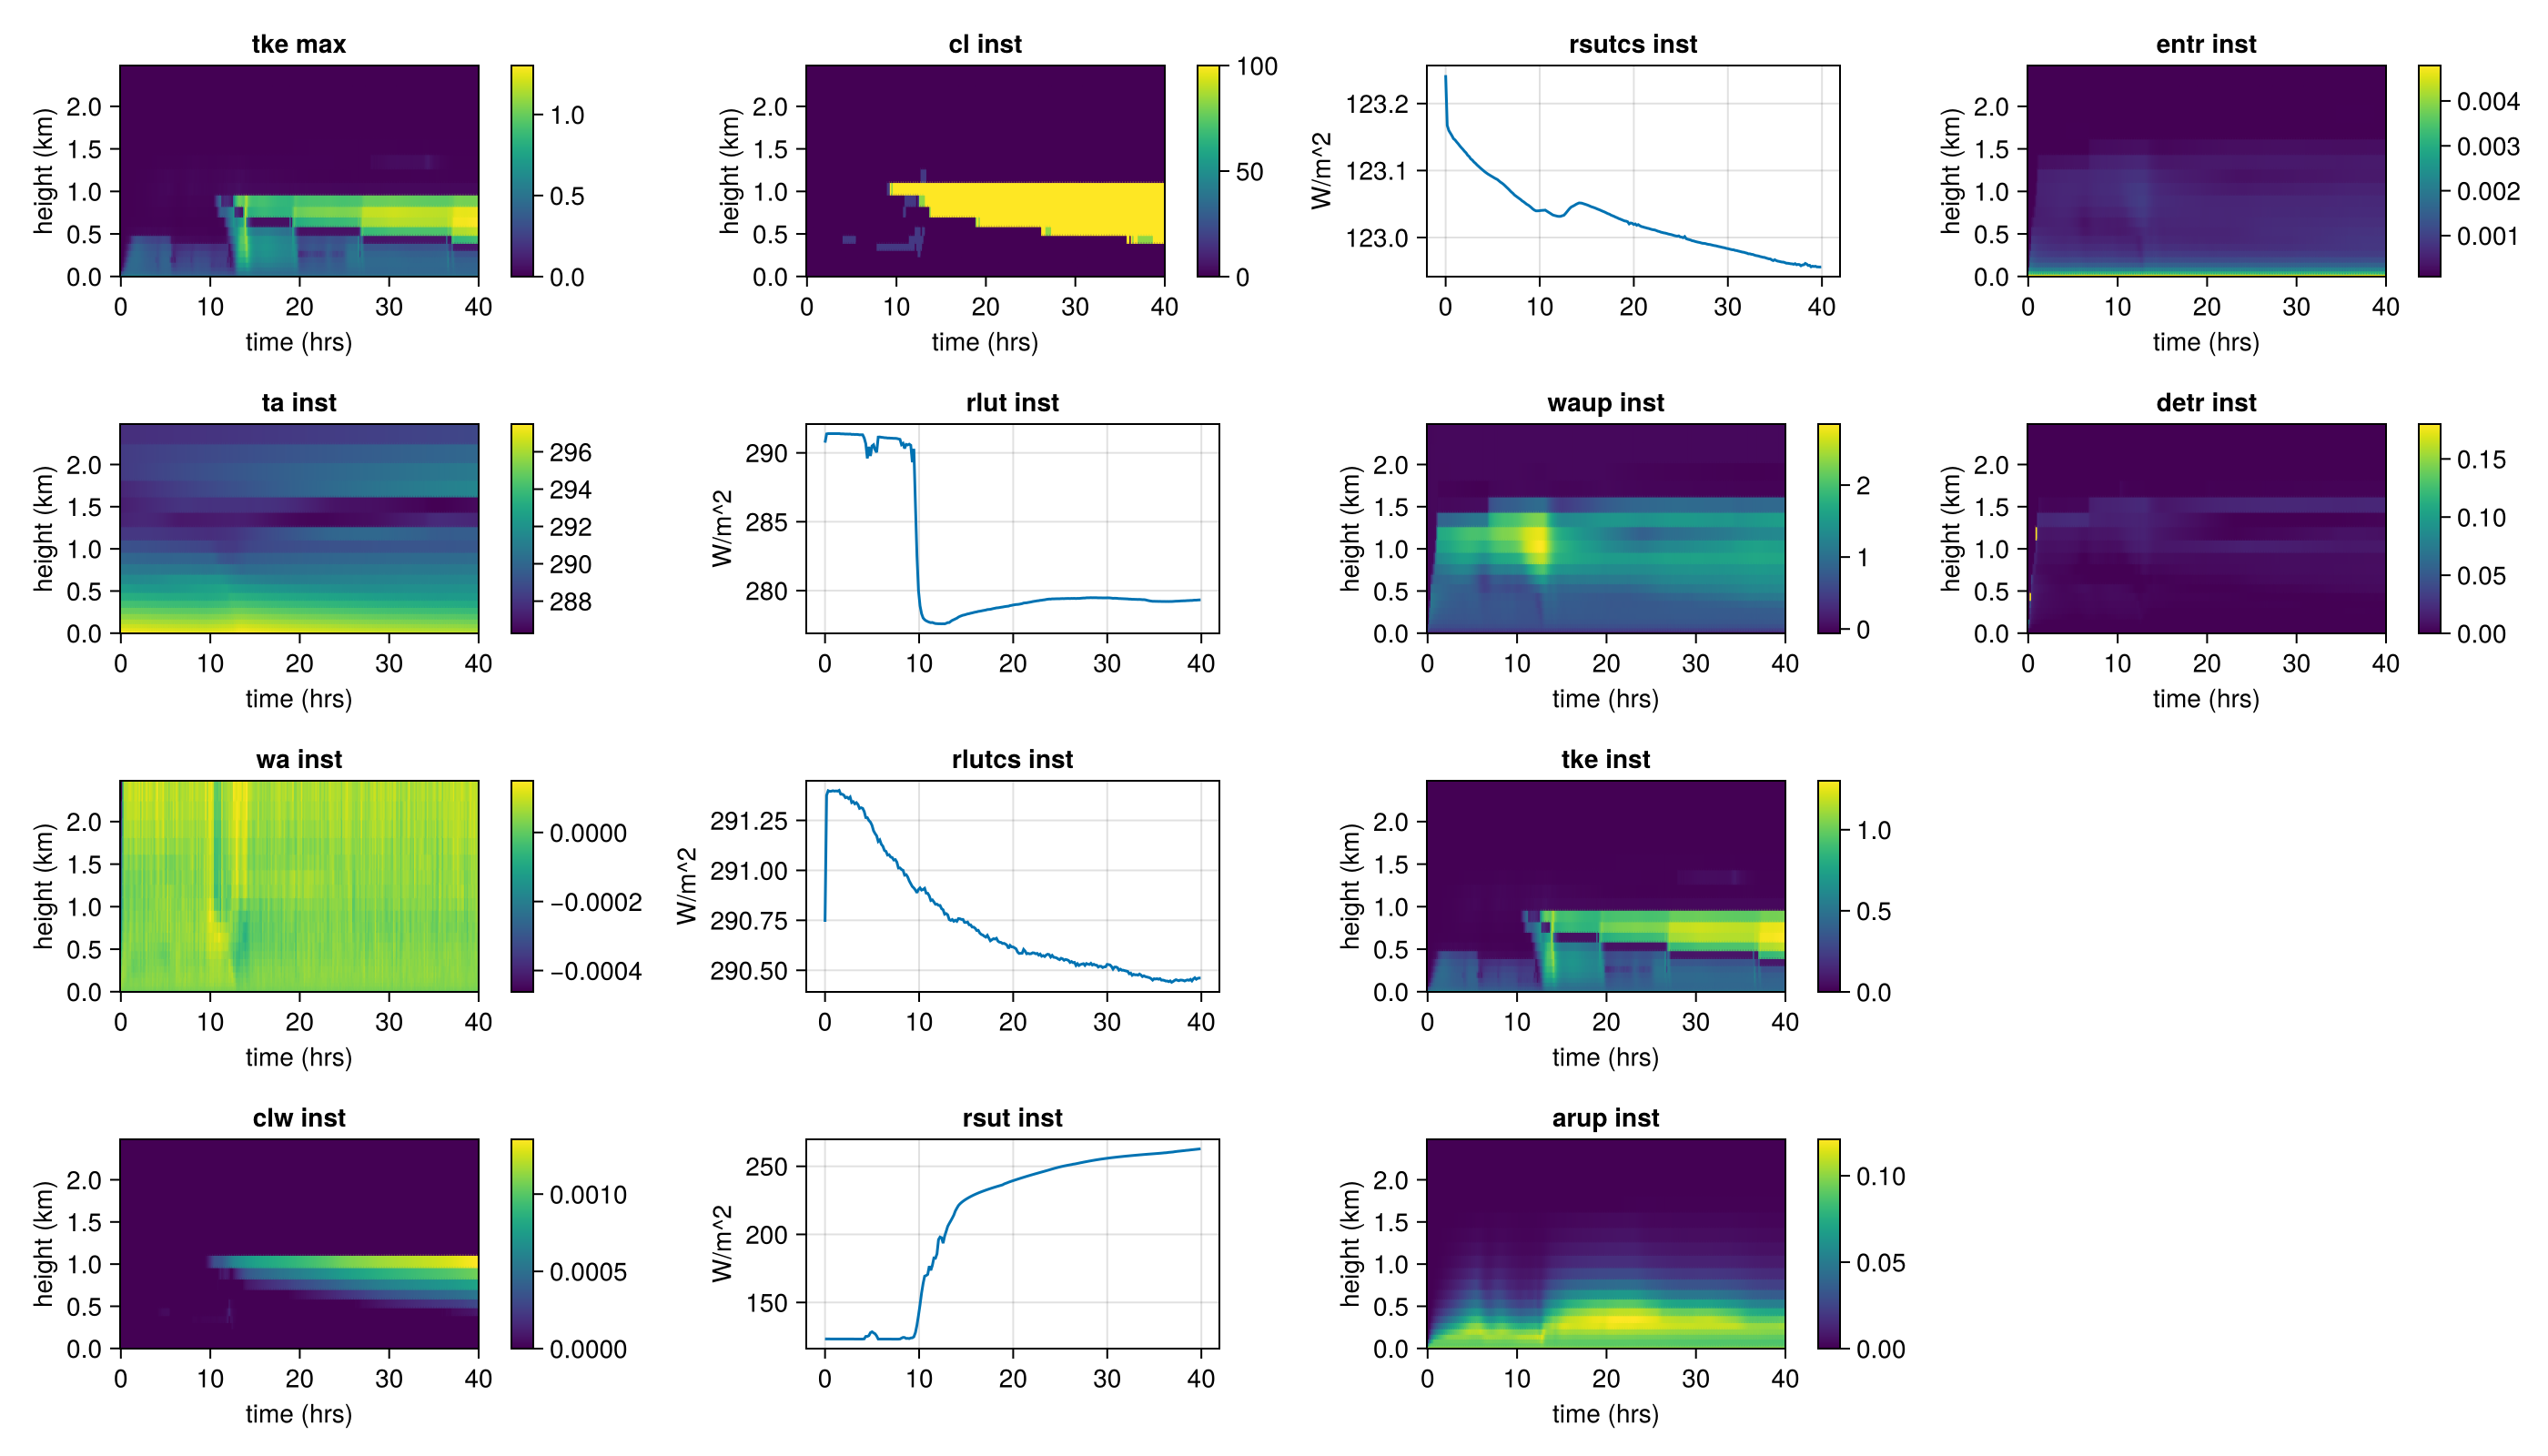

In [151]:
plot_defaults(joinpath("output", "gcm_driven_scm", "iteration_002", "member_006","output_active"))

## Dev function to generate profiles

In [28]:
import YAML
import ClimaAnalysis: SimDir, get, slice, average_xy, available_vars, window, average_time

In [19]:
pwd()
simpath = joinpath("output", "local_calibration", "output_active")
simdir = SimDir(simpath)
variables = collect(available_vars(simdir))

46-element Vector{Any}:
 "rhoa"
 "taen"
 "pr"
 "waup"
 "wa"
 "ua"
 "cli"
 "thetaaup"
 "hussfc"
 "tke"
 ⋮
 "huren"
 "clw"
 "va"
 "husen"
 "pfull"
 "rlutcs"
 "clien"
 "hurup"
 "waen"

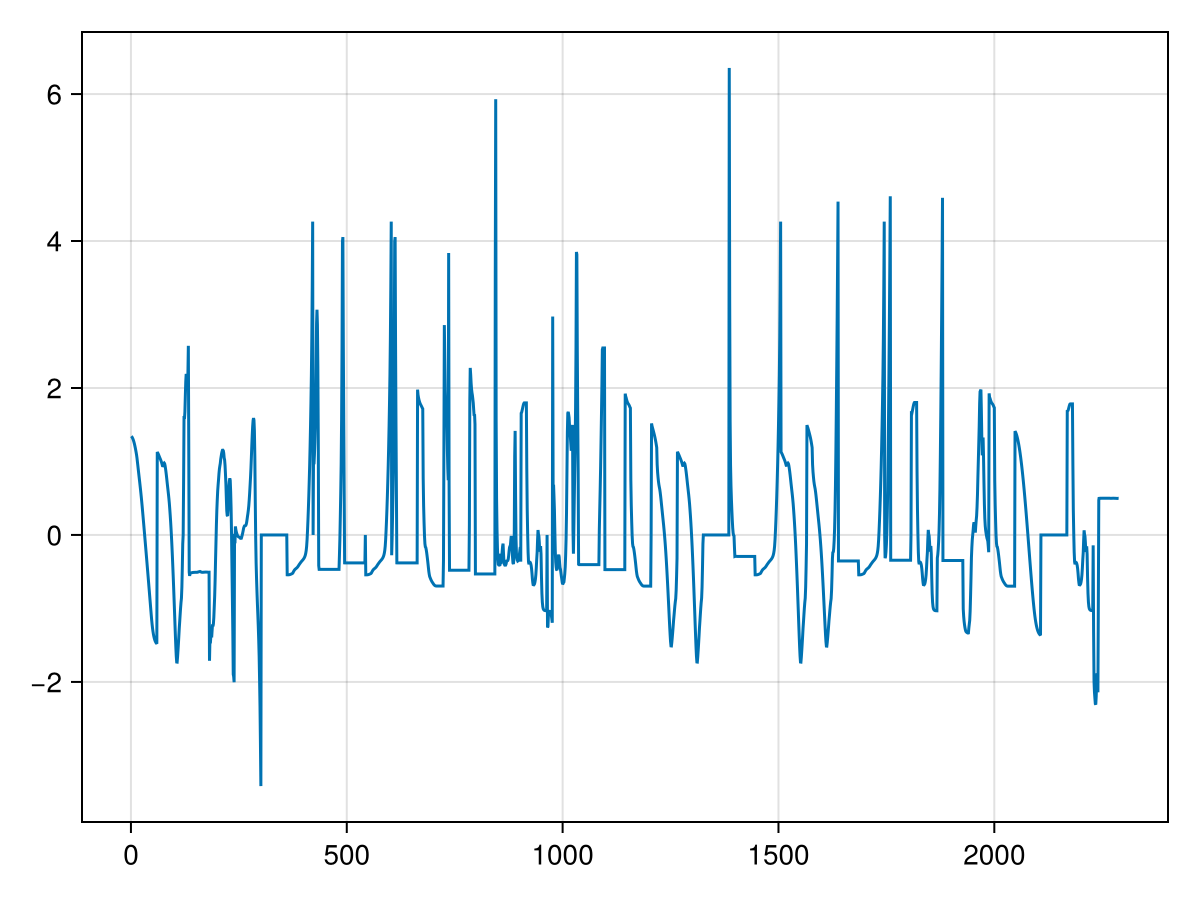

In [57]:
fieldnames(typeof(simdir))
# read in experiment config 
experiment_config = YAML.load_file("experiment_config.yml")

# compute the window time average
da_var = get(simdir; short_name = "ta", reduction = "inst")
da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
da_slice = average_time(da_slice)
da_slice.data[1, 1, :]


function extract_profile(simdir, var, experiment_config)
    da_var = get(simdir; short_name = var, reduction = "inst")
    da_slice = window(da_var, "time", left = experiment_config["g_t_start_sec"], right = experiment_config["g_t_end_sec"])
    da_slice = average_time(da_slice)
    return da_slice.data[1, 1, :]
end

# function to extract all profiles from a simulation directory
function extract_profiles(simdir, experiment_config)
    profiles = Dict()
    for variable in available_vars(simdir)
        profile = extract_profile(simdir, variable, experiment_config)
        profiles[variable] = Dict("profile" => profile, "μ" => mean(profile), "σ²" => var(profile))
    end
    return profiles
end

profiles = extract_profiles(simdir, experiment_config)

# combine profiles into a single vector, normalizing by mean and variance 
function combine_profiles(profiles)
    profile_vec = []
    for variable in available_vars(simdir)
        profile = profiles[variable]["profile"]
        μ = profiles[variable]["μ"]
        σ² = profiles[variable]["σ²"]
        profile = σ² > 0 ? (profile .- μ) ./ sqrt(σ²) : profile .- μ
        append!(profile_vec, profile)
    end
    return profile_vec
end
combined = combine_profiles(profiles)
lines(combined)

In [50]:
mean(extract_profile(simdir, "ta", experiment_config))

258.65765f0